In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from pao.pyomo import *
from pyomo.mpec import *
import math
import datetime

In [2]:
def compare_output(var_old, var_new, bil = True):
    if bil == True:
        base = pd.DataFrame(pd.Series(round_dict(var_old.extract_values(), 2))).reset_index().rename(columns={'level_0':'from_iso3','level_1':'to_iso3',0:'base'})
        new = pd.DataFrame(pd.Series(round_dict(var_new.extract_values(), 2))).reset_index().rename(columns={'level_0':'from_iso3','level_1':'to_iso3',0:'new'})
        compare = base.merge(new, on = ['from_iso3','to_iso3'])
    else:
        base = pd.DataFrame(pd.Series(round_dict(var_old.extract_values(), 2))).reset_index().rename(columns={'index':'iso3',0:'base'})
        new = pd.DataFrame(pd.Series(round_dict(var_new.extract_values(), 2))).reset_index().rename(columns={'index':'iso3',0:'new'})
        compare = base.merge(new, on = ['iso3'])


    compare['new'] = np.where(compare['new']<0.1, int(0), compare['new'])
    compare['base'] = np.where(compare['base']<0.1, int(0), compare['base'])

    compare['diff'] = compare['new'] - compare['base']
    compare['diff_perc'] = np.round(100*(compare['new'] - compare['base']) / compare['base'], 1).replace(np.inf, 100).replace(np.nan, 0)
    
    return compare
    
def round_dict(d, k):
    return {key: float(f"{value:.{k}f}") for key, value in d.items()}

def shock(prod_dict, factor):
    return {key: value * factor for key, value in prod_dict.items()}

def dataframe_model_output(var1, var2):
    predicted = pd.DataFrame(pd.Series(var1.extract_values())).reset_index().rename(columns={'level_0':'from_iso3','level_1':'to_iso3',0:'new'})
    base = pd.DataFrame(pd.Series(var2.extract_values())).reset_index().rename(columns={'level_0':'from_iso3','level_1':'to_iso3',0:'original'})

    validation = predicted.merge(base, on = ['from_iso3','to_iso3'])
    return validation

In [3]:
#### read dummy variables
trade01 = pd.read_excel('Input/Input_dummy/Net_Trade.xls',  index_col=0).replace(np.nan, 0).stack()
tc1 = pd.read_excel('Input/Input_dummy/Transport_costs.xls',  index_col=0).replace(np.nan, 0).replace(0,2).stack()
tariff = pd.read_excel('Input/Input_dummy/TariffsSD.xls',  index_col=0).replace(np.nan, 0).stack()
producer_price = pd.read_excel('Input/Input_dummy/Prodprice.xls', header=None, index_col=0)

### existing trade
existing_trade_binary = trade01.reset_index()
existing_trade_binary[0] = np.where(existing_trade_binary[0]>0, 1, 0)
existing_trade_binary = existing_trade_binary.set_index(['level_0','level_1']).to_dict()[0]

existing_trade = 0.5 * trade01 

###### additional information ####
demand_elas = pd.read_excel('Input/Input_dummy/Demand_Elasticities.xls', header=None, index_col=0)
supply_elas = pd.read_excel('Input/Input_dummy/Supply_Elasticities.xls', header=None, index_col=0)

error = 1e-5

In [4]:
print(datetime.datetime.now())

linear = 'no'

##### MODEL STEP 1 #####
model = ConcreteModel()
model.i = Set(initialize=['KEN','TZA','UGA','ZMB','ZWE'], doc='Countries')

## param
model.trade01 = Param(model.i, model.i, initialize=(trade01+error).to_dict(), doc='initial trade')
model.tc1 = Param(model.i, model.i, initialize=tc1.to_dict(), doc='initial transport')
model.sdt = Param(model.i, model.i, initialize=tariff.to_dict(), doc='tariff')
model.prodprice1 = Param(model.i, initialize=producer_price.to_dict()[1], doc='initial producer price')

model.eps = Param(initialize=3, doc='eps')
model.sigma = Param(initialize=0.0005, doc='sigma')


def excess_demand(model, i):
    return sum(model.trade01[j,i] - model.trade01[i,j] for j in model.i)

model.e = Param(model.i, initialize=excess_demand, doc='excess demand')
model.existing_trade_binary = Param(model.i, model.i, initialize=existing_trade_binary, doc='binary existing trade')
model.existing_trade = Param(model.i, model.i, initialize=(existing_trade+error).to_dict(), doc='existing trade')


####variables ###
model.trade1 = Var(model.i, model.i, initialize = (existing_trade+error).to_dict(), bounds = (error, None), doc='Trade1')

### constraints ###
def balance(model, i):
    return (model.e[i] == sum(model.trade1[j,i] - model.trade1[i,j] for j in model.i))

def internal_trade(model, i):
    return (model.trade1[i,i] == model.trade01[i,i])

model.balance = Constraint(model.i, rule=balance, doc='balance')
model.internal_trade = Constraint(model.i, rule = internal_trade, doc='internal trade')


### objective
def objective_rule(model):
    TTC = 0
    for i in model.i:
        for j in model.i:
            if model.existing_trade_binary[i,j]==1:
                TTC += (model.sdt[i,j] + model.tc1[i,j]) * model.trade1[i,j]
            else:
                TTC += (0.2* model.prodprice1[i] + model.sdt[i,j] + model.tc1[i,j]) * model.trade1[i,j]
    return TTC


def objective_rule_non_linear(model):
    return sum(model.existing_trade_binary[i,j]* (model.sdt[i,j] * model.trade1[i,j] + model.eps/(1+model.eps) * model.tc1[i,j] * pow(model.trade1[i,j]/model.existing_trade[i,j], (1+model.eps)/model.eps) * model.trade1[i,j]) + \
              (1-model.existing_trade_binary[i,j]) * ((0.2* model.prodprice1[i] + model.sdt[i,j] + model.tc1[i,j]) * model.trade1[i,j] + 0.5 * model.sigma * pow(model.trade1[i,j], 2)) for i in model.i for j in model.i)


if linear == 'yes':
    model.objective = Objective(rule=objective_rule, sense=minimize, doc='Define objective function')
    results = SolverFactory("gurobi").solve(model, tee=True)
else:
    model.objective = Objective(rule=objective_rule_non_linear, sense=minimize, doc='Define objective function')
    opt = SolverFactory("ipopt", solver_io='nl')
    opt.options['nlp_scaling_method'] = 'user-scaling'
    results = SolverFactory("ipopt").solve(model)

print('model done', datetime.datetime.now())

2023-11-02 07:35:03.563225
model done 2023-11-02 07:35:03.849826


1.1679033634869944


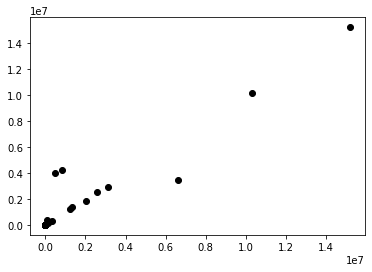

In [5]:
predicted_trade = pd.DataFrame(pd.Series(model.trade1.extract_values())).reset_index().rename(columns={'level_0':'from_iso3','level_1':'to_iso3',0:'t_pred'})
base_trade = pd.DataFrame(pd.Series(model.trade01.extract_values())).reset_index().rename(columns={'level_0':'from_iso3','level_1':'to_iso3',0:'t_exist'})

trade_validation = predicted_trade.merge(base_trade, on = ['from_iso3','to_iso3'])
trade_validation['t_pred'] = np.where(trade_validation['t_pred']<0.01, 0, trade_validation['t_pred'])
trade_validation['error'] = (trade_validation['t_pred']-trade_validation['t_exist'])**2
plt.plot(trade_validation['t_pred'], trade_validation['t_exist'], 'ko')

MSE = np.square(np.subtract(trade_validation['t_exist'].values,trade_validation['t_pred'].values)).mean() 
print(math.sqrt(MSE)/1e6)

In [6]:
print(datetime.datetime.now())

#### get the total demand
tc_sum = pd.Series(model.tc1.extract_values()).sum()
prodprice_sum = pd.Series(model.prodprice1.extract_values()).sum()
trade_sum = pd.Series(model.trade1.extract_values()).sum()

### output of calibration 1 model ###
trade_calibration_1 = pd.Series(model.trade1.extract_values())
trade_calibration_1.mask(trade_calibration_1 <error, error, inplace=True)

count=0
count_max = 200
mu_val = 0.01
d_mu = mu_val/2
pen_val = 1000
##### MODEL STEP 2 #####
model1 =  ConcreteModel()
model1.i = Set(initialize=['KEN','TZA','UGA','ZMB','ZWE'], doc='Countries')

## param - need order magnitude
model1.wtc = Param(initialize=1, doc='weight transport cost') ### 1
model1.wp = Param(initialize=10, doc='weight market supply price') ### 10
model1.wx = Param(initialize=0.01, doc='weight trade') ### 0.01
model1.mu = Param(initialize=mu_val, mutable=True, doc='Parameter for the complementary slackness condition')

### sigma and eps
model1.eps = Param(initialize=3, doc='eps')
model1.sigma = Param(initialize=0.0005, doc='sigma')

### from previous output
model1.trade01 = Param(model1.i, model1.i, initialize = (trade01+error).to_dict(), doc='initial trade')
model1.prodprice1 = Param(model1.i,initialize = model.prodprice1.extract_values(), doc='production price 1')
model1.tc1 = Param(model1.i, model1.i, initialize = model.tc1.extract_values(), doc='transportation cost 1')

model1.trade02 = Param(model1.i, model1.i, initialize = trade_calibration_1.to_dict(), doc='trade02')

model1.sdt = Param(model1.i, model1.i, initialize = tariff.to_dict(), doc='tariff')
model1.existing_trade_binary = Param(model1.i, model1.i, initialize = existing_trade_binary, doc='binary existing trade')
model1.existing_trade = Param(model1.i, model1.i, initialize = (existing_trade+error).to_dict(), doc='binary existing trade')
model1.tc_check = Param(model1.i, model1.i, mutable=True, initialize = 0, doc='binary whether tc model > tc original')


def consprice02(model1, i):
    if model1.existing_trade_binary[i,i]==1:
        return model1.prodprice1[i] + model1.tc1[i,i]
    else:
        min_val_list = []
        for j in model.i:
            if model1.existing_trade_binary[j,i]==1:
                min_val_list.append(model1.prodprice1[j] + model1.tc1[j,i] + model1.sdt[j,i])
            else:
                continue
        return min(min_val_list)

### consumer price
model1.conprice02 = Param(model1.i,initialize= consprice02, doc='consumer price 02', within = NonNegativeReals)

def pi0(model1, i, j):
    if model1.existing_trade_binary[i,j]==1:
        return np.abs(model1.tc1[i,j] * pow(model1.trade02[i,j]/model1.existing_trade[i,j], 1/model1.eps) + model1.sdt[i,j] + model1.prodprice1[i] - model1.conprice02[j])
    else:
        return np.abs(1.2* model1.prodprice1[i] + model1.tc1[i,j] + model1.sdt[i,j] + model1.sigma * model1.trade02[i,j] - model1.conprice02[j]) 

def pen0(model1):
    return model1.mu * sum(model1.pi0[i,j] * model1.trade02[i,j] for i in model1.i for j in model1.i)

def z0(model1):
    return (model1.wtc  * sum(pow(model1.tc1[i,j] - model1.tc1[i,j], 2) for i in model1.i for j in model1.i)) + \
         (model1.wp  * sum(pow(model1.prodprice1[i] - model1.prodprice1[i], 2) for i in model1.i)) + \
        (model1.wx  * sum(pow(model1.trade02[i,j] - model1.trade01[i,j], 2) for i in model1.i for j in model1.i))

def zz0(model1):
    return model1.z0 + model1.pen0


model1.pi0= Param(model1.i, model1.i, initialize=pi0, doc='pi0',  within = NonNegativeReals)
model1.pen0= Param(initialize=pen0, doc='pen0', within = NonNegativeReals)
model1.z0= Param(initialize=z0, doc='z0', within = NonNegativeReals)
model1.zz0= Param(initialize=zz0, doc='zz0', within = NonNegativeReals)


print(model1.z0.extract_values()[None], model1.pen0.extract_values()[None])


#### variables #####
model1.calib= Param(model1.i, model1.i, mutable=True, initialize = 0,  doc='calib')

model1.z= Var(initialize=model1.z0.extract_values()[None], within = NonNegativeReals, doc='z')
model1.zz= Var(initialize=model1.zz0.extract_values()[None], within =  NonNegativeReals, doc='zz')

def tc2_bounds(model1, i,j):
    return (0.5 * model1.tc1[i,j], None)

model1.tc2= Var(model1.i, model1.i, initialize=model1.tc1.extract_values(), bounds = tc2_bounds,  doc='tc2')
model1.prodprice2= Var(model1.i, initialize=model1.prodprice1.extract_values(), within = NonNegativeReals, doc='prodprice2')
model1.conprice2= Var(model1.i, initialize=model1.conprice02.extract_values(), within = NonNegativeReals, doc='conprice2')
model1.trade2= Var(model1.i, model1.i, initialize=model1.trade02.extract_values(), bounds = (error, None), doc='conprice2')

model1.pi= Var(model1.i, model1.i, initialize=model1.pi0.extract_values(), within = NonNegativeReals, doc='pi')
model1.pen= Var(initialize=model1.pen0.extract_values()[None], within = NonNegativeReals, doc='pen')

    
### constraints ###
def eq_obj(model1):
    return model1.z == \
        (model1.wtc  * sum(pow(model1.tc2[i,j] - model1.tc1[i,j], 2) for i in model1.i for j in model1.i)) + \
        (model1.wp  * sum(pow(model1.prodprice2[i] - model1.prodprice1[i], 2) for i in model1.i)) + \
        (model1.wx  * sum(pow(model1.trade2[i,j] - model1.trade01[i,j], 2) for i in model1.i for j in model1.i))

def eq_PRLINK1(model1, i, j):
    if model1.existing_trade_binary[i,j]==1:
         return model1.prodprice2[i] +  model1.calib[i,j] + model1.sdt[i,j] + (model1.tc2[i,j]-model1.calib[i,j]) * pow(model1.trade2[i,j]/model1.existing_trade[i,j], 1/model1.eps) == model1.conprice2[j] + model1.pi[i,j]
    else:
        return 1.2* model1.prodprice2[i] + model1.calib[i,j] + (model1.tc2[i,j]-model1.calib[i,j]) + model1.sdt[i,j] + model1.sigma * model1.trade2[i,j]  == model1.conprice2[j] + model1.pi[i,j]

def eq_pen(model1):
    return  model1.pen == model1.mu * sum(model1.pi[i,j] * model1.trade2[i,j] for i in model1.i for j in model1.i)

def eq_zz(model1):
    return model1.z + model1.pen


model1.obj = Constraint(rule = eq_obj, doc='eq error')
model1.eq_PRLINK1 = Constraint(model.i, model.i, rule = eq_PRLINK1, doc=' eq price link')
model1.eq_pen = Constraint(rule = eq_pen, doc='eq penalty')

### objective
model1.objective = Objective(rule = eq_zz, sense=minimize, doc='Define objective function')


opt = SolverFactory("ipopt", solver_io='nl')
opt.options['max_iter'] = 2000
opt.options['nlp_scaling_method'] = 'user-scaling'
opt.options['halt_on_ampl_error'] = 'no'
opt.options['tol'] = 1e-1
opt.options['mumps_mem_percent'] = 100
results = opt.solve(model1)

trade_error = np.sum((pd.Series(model1.trade2.extract_values())-pd.Series(model1.trade01.extract_values()))**2)/1e6
transport_error = np.sum((pd.Series(model1.tc2.extract_values())-pd.Series(model1.tc1.extract_values()))**2)/1e6
price_error = np.sum((pd.Series(model1.prodprice2.extract_values())-pd.Series(model1.prodprice1.extract_values()))**2)/1e6

print('trade error:',trade_error, trade_error*model1.wx.extract_values()[None])
print('transport error:',transport_error, transport_error*model1.wtc.extract_values()[None])
print('price error:',price_error, price_error*model1.wp.extract_values()[None])

while (pen_val/mu_val >= 0.0001) & (count<count_max):# & (model1.pen.get_values()[None]/mu_val< pen_val/mu_val):
    #### add penality
    mu_val = mu_val + d_mu
    pen_val = model1.pen.get_values()[None]
    z_val = model1.z.get_values()[None]
    count +=1
    print(count, mu_val, z_val, pen_val, pen_val/mu_val)
    
    ## get the tc_val
    tc_val = dataframe_model_output(var1 = model1.tc2, var2 = model1.tc1)
    tc_val['dummy'] = np.where(tc_val['new']>tc_val['original'], 1,0)
    tc_val['calib'] = tc_val['dummy'] * (tc_val['new']-tc_val['original'])
    tc_val['calib'] = np.where(tc_val['calib']<0, 0, tc_val['calib'])
    
    ### update mu
    model1.mu = mu_val
    ### update calibration
    model1.calib.clear()
    model1.calib._constructed = False
    model1.calib.construct(tc_val.set_index(['from_iso3','to_iso3'])['calib'].to_dict())
     
    results = opt.solve(model1)
    
    trade_error = np.sum((pd.Series(model1.trade2.extract_values())-pd.Series(model1.trade01.extract_values()))**2)
    transport_error = np.sum((pd.Series(model1.tc2.extract_values())-pd.Series(model1.tc1.extract_values()))**2)
    price_error = np.sum((pd.Series(model1.prodprice2.extract_values())-pd.Series(model1.prodprice1.extract_values()))**2)
    
    print('trade error:',trade_error, trade_error*model1.wx.extract_values()[None])
    print('transport error:',transport_error, transport_error*model1.wtc.extract_values()[None])
    print('price error:',price_error, price_error*model1.wp.extract_values()[None])

print(datetime.datetime.now())                                            

2023-11-02 07:35:04.051254
340999566611.05865 2330906.6909344234
    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: Ipopt 3.14.9\x3a Maximum Number of Iterations
        Exceeded.
trade error: 32067734.593552444 320677.34593552444
transport error: 0.0004933386620185145 0.0004933386620185145
price error: 0.03099997309554257 0.3099997309554257
1 0.015 320577651806.41034 2227937.5991017544 148529173.2734503
trade error: 0.01244133756580602 0.00012441337565806022
transport error: 2707.8429824105356 2707.8429824105356
price error: 83.37739327204638 833.7739327204638
2 0.02 3541.617039008399 9.724225788139095e-06 0.00048621128940695474
trade error: 0.012417409304250969 0.00012417409304250969
transport error: 2707.842949622619 2707.842949622619
price error: 83.37739374906914 833.7739374906914
3 0.025 3541.6170112331124 9.436117279447698e-06 0.00037744469117790793
trade error: 0.012418584803131454 0.00012418584803131454
transport error: 2707.842

2.228492622673732e-08


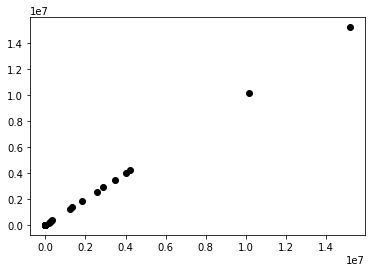

In [7]:
predicted_trade = pd.DataFrame(pd.Series(model1.trade2.extract_values())).reset_index().rename(columns={'level_0':'from_iso3','level_1':'to_iso3',0:'t_pred'})
base_trade = pd.DataFrame(pd.Series(model.trade01.extract_values())).reset_index().rename(columns={'level_0':'from_iso3','level_1':'to_iso3',0:'t_exist'})


trade_validation = predicted_trade.merge(base_trade, on = ['from_iso3','to_iso3'])
trade_validation['t_pred'] = np.where(trade_validation['t_pred']<0.01, 0, trade_validation['t_pred'])

plt.plot(trade_validation['t_pred'], trade_validation['t_exist'], 'ko')

MSE = np.square(np.subtract(trade_validation['t_exist'].values,trade_validation['t_pred'].values)).mean() 
print(math.sqrt(MSE)/1e6)

In [8]:
round_dict(model1.conprice02.extract_values(), 2)

{'KEN': 184.82, 'TZA': 184.82, 'UGA': 184.82, 'ZMB': 184.82, 'ZWE': 186.75}

In [9]:
round_dict(model1.conprice2.get_values(), 2)

{'KEN': 223.49, 'TZA': 188.44, 'UGA': 186.93, 'ZMB': 196.37, 'ZWE': 227.5}

In [10]:
round_dict(model1.prodprice1.extract_values(), 2)

{'KEN': 182.82, 'TZA': 182.82, 'UGA': 182.82, 'ZMB': 182.82, 'ZWE': 196.03}

In [11]:
round_dict(model1.prodprice2.get_values(), 2)

{'KEN': 186.22, 'TZA': 175.0, 'UGA': 184.41, 'ZMB': 185.66, 'ZWE': 196.03}

In [12]:
def adjust_supply(dict_val, factor ):
    new_dict = {}
    for key, value in dict_val.items():
        #if key == 'ZMB':
        new_dict[key] = value * factor
        #else:
            #new_dict[key] = value
    return new_dict

def adjust_prodprice(dict_val, factor ):
    new_dict = {}
    for key, value in dict_val.items():
        new_dict[key] = value * (1/factor)

    return new_dict

def add_error_demand(dict_val, error):
    new_dict = {}
    for key, value in dict_val.items():
        new_dict[key] = value + error*5

    return new_dict

def add_error_supply(dict_val, error):
    new_dict = {}
    for key, value in dict_val.items():
        new_dict[key] = value + error*5

    return new_dict


In [13]:
### demand and supply
demand_df = (pd.Series(model1.trade2.extract_values()).reset_index().groupby(['level_1'])[0].sum()).to_dict()
demand_df  = add_error_demand(dict_val = demand_df , error = error)
supply_df = (pd.Series(model1.trade2.extract_values()).reset_index().groupby(['level_0'])[0].sum()).to_dict()
supply_df  = add_error_supply(dict_val = supply_df , error = error)

### output of calibration 1 model ###
trade_calibration_2 = pd.Series(model1.trade2.extract_values())
trade_calibration_2.mask(trade_calibration_2 <error, error, inplace=True)

### Base scenario
base_scen = 'yes'

### Shock settings ####
if base_scen == 'yes':
    price_shock = 'no'
    tariff_reduction ='no'
    transport_increase = 'no'
    transport_increase_two_side = 'no'
    supply_shock = 'no'
else:
    price_shock = 'no'
    tariff_reduction ='no'
    transport_increase = 'no' ### export restriction
    transport_increase_two_side = 'no' ### trade disruption
    supply_shock = 'yes'

factor_price = 0.2 ### 20% increase in prodprice2
factor_supply = 0.8 ### 20% decrease in supply

##### MODEL STEP 3 #####
model2 =  ConcreteModel()
model2.i = Set(initialize=['KEN','TZA','UGA','ZMB','ZWE'], doc='Countries')          

#### Parameters #####
model2.prodprice03 = Param(model2.i,initialize= model1.prodprice2.get_values(), doc='production price 03')

if price_shock == 'yes':
    model2.sup_cost = Param(model2.i, initialize=100, doc='sup cost')
else:
    model2.sup_cost = Param(model2.i, initialize=0, doc='sup cost')

model2.trade03 = Param(model2.i, model2.i, initialize= trade_calibration_2.to_dict(), doc='trade03')
model2.conprice03 = Param(model2.i,initialize= model1.conprice2.get_values(), doc='consumer price 03')
model2.tc03 = Param(model2.i, model2.i, initialize= model1.tc2.extract_values(), doc='transportation cost 03')
model2.calib = Param(model2.i, model2.i, initialize= model1.calib.extract_values(), doc='transportation cost 03')


def sup_cost(model2, i, j):
    if j == 'UGA' and i == 'UGA':
        return 0
    elif i == 'UGA' and j !='UGA':
        return 50
    else:
        return 0

def sup_cost_two_side(model2, i, j):
    if j == 'UGA' and i == 'UGA':
        return 0
    elif j == 'UGA' and i !='UGA':
        return 50
    elif i == 'UGA' and j !='UGA':
        return 50
    else:
        return 0
    
#### Shock transportation ####
if transport_increase == 'yes':
    model2.sup_cost_tc = Param(model2.i, model2.i, initialize=sup_cost, doc='sup cost')
elif transport_increase_two_side == 'yes':
    model2.sup_cost_tc = Param(model2.i, model2.i, initialize=sup_cost_two_side, doc='sup cost')
else:
    model2.sup_cost_tc = Param(model2.i, model2.i, initialize=0, doc='sup cost')

#### Tariff reduction ####
if tariff_reduction == 'yes':
    tariff_shock = shock(prod_dict = tariff.to_dict(), factor = 0.5)
    model2.sdt = Param(model2.i, model2.i, initialize=tariff_shock, doc='tariff')
else:
    model2.sdt = Param(model2.i, model2.i, initialize=tariff.to_dict(), doc='tariff')


#### Demand and Supply Elasticities ####
model2.Ed = Param(model2.i,initialize=(demand_elas).to_dict()[1], doc='demand elasticity')
model2.Es = Param(model2.i,initialize=supply_elas.to_dict()[1], doc='supply elasticity')


if supply_shock == 'yes':
    supply03_shock = adjust_supply(dict_val = supply_df, factor = factor_supply)
    model2.supply3_init = Param(model2.i,initialize=supply03_shock, doc='supply initial')
else:
    model2.supply3_init = Param(model2.i,initialize=supply_df, doc='supply initial')

model2.demand3_init = Param(model2.i,initialize=demand_df, doc='supply initial')

def init_supply(model2, i):
    return model2.supply3_init[i] + 0.2 *model2.demand3_init[i]

def init_demand(model2, i):
    return model2.demand3_init[i] + 0 * model2.demand3_init[i]

model2.supply_total = Param(model2.i,initialize=init_supply, doc='supply initial')


model2.supply03 = Param(model2.i,initialize=supply_df, doc='supply initial')
model2.demand03 = Param(model2.i,initialize=init_demand, doc='demand initial')

def supply_shock(model2, i):
    return model2.supply03[i] - model2.supply3_init[i]

model2.supply_shock = Param(model2.i, initialize=supply_shock)


print(np.sum(list(model2.demand03.values()))/1e6)
print(np.sum(list(model2.supply03.values()))/1e6)
print(np.sum(list(model2.supply3_init.values()))/1e6)
print(np.sum(list(model2.supply_total.values()))/1e6)

model2.epsilon = Param(initialize=0.001, doc='epsilon')
model2.eps = Param(initialize=3, doc='eps')
model2.sigma = Param(initialize=0.0005, doc='sigma')
model2.existing_trade_binary = Param(model2.i, model2.i, initialize=existing_trade_binary, doc='binary existing trade')
model2.existing_trade = Param(model2.i, model2.i, initialize = (existing_trade+error).to_dict(), doc='binary existing trade')

    
def B(model2, i):
    if model2.demand03[i]>1:
        return model2.conprice03[i]/(model2.demand03[i]*model2.Ed[i])
    else:
        ### take average
        B_sum = 0; count = 0
        for j in model2.i:
            if model2.demand03[j]>1:
                B_sum+=model2.conprice03[j]/(model2.demand03[j]*model2.Ed[j])
                count+=1
        
        return B_sum/count
    
    
def D(model2, i):
    if model2.supply03[i]>1:
        return model2.prodprice03[i]/(model2.supply03[i]*model2.Es[i])
    else:
        ### take average
        D_sum = 0; count = 0
        for j in model2.i:
            if model2.supply03[j]>1:
                D_sum+=model2.prodprice03[j]/(model2.supply03[j]*model2.Es[j])
                count+=1
        
        return D_sum/count
    
def A(model2, i):
    if model2.demand03[i]>1:
        return model2.conprice03[i] + model2.B[i] * model2.demand03[i]
    else:
        return model2.conprice03[i] + model2.B[i] * model2.demand03[i] - model2.epsilon    

    
def C(model2, i):
    if model2.supply03[i]>1:
        return model2.prodprice03[i] - model2.D[i] * model2.supply03[i]
    else:
        return model2.prodprice03[i] - model2.D[i] * model2.supply03[i] + model2.epsilon 



model2.B = Param(model2.i,initialize=B, doc='B: Absolute value of the inverse demand function slopes p=f(q)')
model2.A = Param(model2.i,initialize=A, doc='A: Inverse demand function intercepts p=f(q)')

model2.D = Param(model2.i,initialize=D, doc='D: Absolute value of the inverse supply function slopes p=f(q)')
model2.C = Param(model2.i,initialize=C, doc='C: Inverse supply function intercepts p=f(q)')


#### variables ####
model2.prodprice3 = Var(model2.i,initialize=model2.prodprice03.extract_values(),  within = NonNegativeReals, doc='production price 3')
model2.conprice3 = Var(model2.i,initialize=model2.conprice03.extract_values(),  within = NonNegativeReals, doc='consumer price 3')

model2.demand = Var(model2.i,initialize=model2.demand03.extract_values(),  bounds = (error * 5, None), doc='demand')

def supply_bounds(model1, i):
    return (5*error, model2.supply_total[i])

model2.supply = Var(model2.i,initialize = model2.supply_total.extract_values(),  bounds =supply_bounds, doc='supply')
model2.trade3 = Var(model2.i, model2.i, initialize= trade_calibration_2.to_dict(),  bounds = (error, None), doc='trade3')

### equations
def eq_PROD(model2, i):
        return complements(model2.supply[i] == sum(model2.trade3[i,j] for j in model2.i), model2.prodprice3[i]>0)

def eq_DEM(model2, i):
        return complements(sum(model2.trade3[j,i] for j in model2.i) == model2.demand[i], model2.conprice3[i]>0)

def eq_DPRICEDIF(model2, i):
        return complements(model2.conprice3[i] == model2.A[i] - model2.B[i] * model2.demand[i], model2.demand[i]>=(error*5))

def eq_SPRICEDIF(model2, i):
        return complements(model2.C[i] + (model2.supply_shock[i]*model2.D[i]) + (model2.D[i] * model2.supply[i]) == model2.prodprice3[i] , model2.supply[i]<=model2.supply_total[i])
        #return complements(model2.C[i] + model2.D[i] * model2.supply[i] >= model2.prodprice3[i] , model2.supply[i]>=0)

def eq_PRLINK2(model2, i, j):
    if model2.existing_trade_binary[i,j]==1:
        return complements(model2.prodprice3[i] +model2.sup_cost[i] + model2.calib[i,j] + model2.sup_cost_tc[i,j]+ model2.sdt[i,j] + (model2.tc03[i,j]-model2.calib[i,j]) * pow(model2.trade3[i,j]/model2.existing_trade[i,j], 1/model2.eps) >= model2.conprice3[j], model2.trade3[i,j]>=error)
    else:
        return complements(1.2* model2.prodprice3[i]+ model2.sup_cost[i] + model2.calib[i,j] + (model2.tc03[i,j]-model2.calib[i,j]) + model2.sup_cost_tc[i,j] + model2.sdt[i,j] + model2.sigma * model2.trade3[i,j]  >= model2.conprice3[j], model2.trade3[i,j]>=error)


### add constraints
model2.eq_PROD = Complementarity(model2.i, rule = eq_PROD, doc='Production >= quantity shipped')

model2.eq_DEM = Complementarity(model2.i, rule = eq_DEM, doc='Demand <= quantity shipped')
model2.eq_DPRICEDIF = Complementarity(model2.i, rule = eq_DPRICEDIF, doc='difference market demand price and local demand price')

model2.eq_SPRICEDIF = Complementarity(model2.i, rule = eq_SPRICEDIF, doc='difference market supply price and local supply price')
#model2.eq_SUPPLY = Complementarity(model2.i, rule = eq_SUPPLY, doc='difference market supply price and local supply price')


model2.eq_PRLINK2 = Complementarity(model2.i, model2.i, rule = eq_PRLINK2, doc='price chain 2')

### solve 
TransformationFactory('mpec.simple_nonlinear').apply_to(model2)

### choose solver
opt = SolverFactory('ipopt', solver_io='nl')
opt.options['nlp_scaling_method'] = 'user-scaling'
opt.options['mumps_mem_percent'] = 10000
opt.options['halt_on_ampl_error'] = 'no'
opt.options['tol'] = 1e-3
opt.options['max_iter'] = 5000


result=opt.solve(model2)

if base_scen == 'yes':
    B_base  = model2.B
    D_base = model2.D
    trade_base  = model2.trade3
    demand_base = model2.demand
    supply_base = model2.supply
    prodprice_base = model2.prodprice3
    conprice_base = model2.conprice3

consumer_surplus_base = pd.Series(B_base.extract_values())  * (pd.Series(demand_base.get_values())**2) / (2*1e9)
producer_surplus_base = pd.Series(D_base.extract_values())  * (pd.Series(supply_base.get_values())**2) / (2*1e9)


consumer_surplus = pd.Series(model2.B.extract_values())  * (pd.Series(model2.demand.get_values())**2) / (2*1e9)
producer_surplus = pd.Series(model2.D.extract_values())  * (pd.Series(model2.supply.get_values())**2) / (2*1e9)

print('Welfare:', np.sum(consumer_surplus_base), np.sum(producer_surplus_base))
print('Welfare:', np.sum(consumer_surplus), np.sum(producer_surplus))

47.996648066428556
47.996648066428556
47.996648066428556
57.59597767971426
Welfare: 1371.0034564690104 3.090280124060373
Welfare: 1371.0034564690104 3.090280124060373


In [74]:
### compare output
trade = compare_output(var_old = trade_base, var_new = model2.trade3, bil = True)  
demand = compare_output(var_old = demand_base, var_new = model2.demand, bil = False)
supply = compare_output(var_old = supply_base, var_new = model2.supply, bil = False)
prodprice = compare_output(var_old = prodprice_base, var_new = model2.prodprice3, bil = False)
conprice = compare_output(var_old = conprice_base, var_new = model2.conprice3, bil = False)

In [75]:
print(demand['base'].sum()/1e6, demand['new'].sum()/1e6, pd.Series(demand_df).sum()/1e6)
demand

47.99664806 48.086452869999995 47.996648066428556


,iso3,base,new,diff,diff_perc
0,KEN,22674627.45,22760362.90,85735.45,0.4
1,TZA,6789878.95,6793349.36,3470.41,0.1
2,UGA,1350000.00,1350020.55,20.55,0.0
3,ZMB,6296414.19,6296938.35,524.16,0.0
4,ZWE,10885727.47,10885781.71,54.24,0.0


In [76]:
print(supply['base'].sum()/1e6, supply['new'].sum()/1e6, pd.Series(supply_df).sum()/1e6)

supply

47.99664807 48.086452869999995 47.996648066428556


,iso3,base,new,diff,diff_perc
0,KEN,15792561.08,16057752.83,265191.75,1.7
1,TZA,8552620.94,8429711.28,-122909.66,-1.4
2,UGA,12230165.04,12116937.52,-113227.52,-0.9
3,ZMB,11421301.01,11482051.24,60750.23,0.5
4,ZWE,0.00,0.00,0.00,0.0


In [77]:
prodprice

,iso3,base,new,diff,diff_perc
0,KEN,186.22,188.06,1.84,1.0
1,TZA,174.27,173.06,-1.21,-0.7
2,UGA,184.41,182.99,-1.42,-0.8
3,ZMB,187.47,186.32,-1.15,-0.6
4,ZWE,196.03,196.03,0.00,0.0


In [78]:
conprice

,iso3,base,new,diff,diff_perc
0,KEN,219.76,218.20,-1.56,-0.7
1,TZA,186.35,185.11,-1.24,-0.7
2,UGA,186.93,185.51,-1.42,-0.8
3,ZMB,196.26,195.09,-1.17,-0.6
4,ZWE,221.74,220.61,-1.13,-0.5


In [72]:
trade

,from_iso3,to_iso3,base,new,diff,diff_perc
0,KEN,KEN,15245957.19,17035693.55,1789736.36,11.7
1,KEN,TZA,0.00,0.00,0.00,0.0
2,KEN,UGA,0.00,0.00,0.00,0.0
3,KEN,ZMB,329043.25,28490.80,-300552.45,-91.3
4,KEN,ZWE,217560.64,106028.51,-111532.13,-51.3
5,TZA,KEN,0.00,1277241.57,1277241.57,100.0
6,TZA,TZA,6319944.11,4739812.58,-1580131.53,-25.0
7,TZA,UGA,0.00,0.00,0.00,0.0
8,TZA,ZMB,2229781.06,2155697.92,-74083.14,-3.3
9,TZA,ZWE,2895.77,26146.67,23250.90,802.9


In [65]:
model2.supply_shock.extract_values()

{'KEN': -1579256.1080913395,
 'TZA': -855262.0935165528,
 'UGA': -1223016.5041648466,
 'ZMB': -1142130.100628592,
 'ZWE': -0.00024152814476409218}

In [90]:
### domestic production ###
dom_prod = trade[trade['from_iso3']==trade['to_iso3']].groupby(['from_iso3'])[['base','new','diff']].sum().reset_index()
dom_prod['perc'] = 100*dom_prod['diff']/dom_prod['base']
print(dom_prod['new'].sum()/1e3, dom_prod['base'].sum()/1e3)
dom_prod

23861.2795 23861.2795


,from_iso3,base,new,diff,perc
0,KEN,15245957.19,15245957.19,0.0,0.0
1,TZA,6319944.11,6319944.11,0.0,0.0
2,UGA,1350000.00,1350000.00,0.0,0.0
3,ZMB,945378.20,945378.20,0.0,0.0
4,ZWE,0.00,0.00,0.0,NaN


In [91]:
### export ###
export_val = trade[trade['from_iso3']!=trade['to_iso3']].groupby(['from_iso3'])[['base','new','diff']].sum().reset_index()
export_val['perc'] = 100*export_val ['diff']/export_val['base']
print(export_val['new'].sum()/1e3, export_val['base'].sum()/1e3)

export_val

24135.36857 24135.36857


,from_iso3,base,new,diff,perc
0,KEN,546603.89,546603.89,0.0,0.0
1,TZA,2232676.83,2232676.83,0.0,0.0
2,UGA,10880165.04,10880165.04,0.0,0.0
3,ZMB,10475922.81,10475922.81,0.0,0.0
4,ZWE,0.00,0.00,0.0,NaN


In [92]:
## import ###
import_val = trade[trade['from_iso3']!=trade['to_iso3']].groupby(['to_iso3'])[['base','new','diff']].sum().reset_index()
import_val['perc'] = 100*import_val ['diff']/import_val['base']
print(import_val['new'].sum()/1e3, import_val['base'].sum()/1e3)
import_val

24135.36857 24135.36857


,to_iso3,base,new,diff,perc
0,KEN,7428670.26,7428670.26,0.0,0.0
1,TZA,469934.84,469934.84,0.0,0.0
2,UGA,0.00,0.00,0.0,NaN
3,ZMB,5351035.99,5351035.99,0.0,0.0
4,ZWE,10885727.48,10885727.48,0.0,0.0


1.5546948994884486


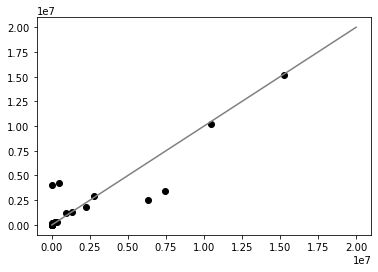

In [25]:
predicted_trade = pd.DataFrame(pd.Series(trade_base.extract_values())).reset_index().rename(columns={'level_0':'from_iso3','level_1':'to_iso3',0:'t_pred'})
base_trade = pd.DataFrame(pd.Series(model1.trade01.extract_values())).reset_index().rename(columns={'level_0':'from_iso3','level_1':'to_iso3',0:'t_exist'})


trade_validation = predicted_trade.merge(base_trade, on = ['from_iso3','to_iso3'])
trade_validation['t_pred'] = np.where(trade_validation['t_pred']<0.01, 0, trade_validation['t_pred'])

plt.plot(trade_validation['t_pred'], trade_validation['t_exist'], 'ko')
plt.plot(np.linspace(0,2e7,100),np.linspace(0,2e7,100), color = 'grey' )
MSE = np.square(np.subtract(trade_validation['t_exist'].values,trade_validation['t_pred'].values)).mean() 
print(math.sqrt(MSE)/1e6)